In [1]:
##==================================================
##
## Script name: Heterogenous Panel Simulation
##
##
## Purpose of script: Given different parametrizations of
##                    recruitment patterns and outcomes,
##                    simulate a panel of heterogeneous
##                    treatment effects for stress testing the MC estimator
## Author: Shosh Vasserman
##
## Date Last Edited: 09-27-2021
##
## Email: svass@stanford.edu
##
## Input:  TBC

In [6]:
# Imports
using Distributions
using LinearAlgebra
using DataFrames, CSV
using Distributions
using Random
using Plots
using StatsPlots

In [7]:
# Type definitions

mutable struct Date
    id::Integer ## day of the year
    fe::AbstractFloat ## This could be a date fixed effect or a vector of date characteristics
end

mutable struct BasicOutcome
    date::Integer ## date of trip
    y::AbstractFloat ## outcome
end

mutable struct BasicRider
    id::Integer ## rider ID
    cohort_id::Integer ## rider's cohord ID -- in order of the cohort array
    X::Vector{AbstractFloat}  ## rider characteristics
    treatment_date::Integer ## Rider's date of entry
    min_date::Integer ## First date anyone in the cohort can enter; Assume time is indexed from 0 to 365
    max_date::Integer ## Laste date anyone in the cohort can enter; Note -- cohort entries may overlap (maybe...)
    outcomes::Vector{BasicOutcome} ## outcome draws
end

mutable struct BasicCohort
    treatdate_coef::AbstractFloat ## alpha_t for the cohort
end


In [8]:
## Set seed
rng_seed = MersenneTwister(1234);

In [9]:
## Define Options

global treatment_date_fn_of_X = false ## Should the treatment date depend on rider covars X?
global te_fn_of_X = true              ## Should treatment effects depend on rider covars X?
global te_fn_of_time = true           ## Should treatment effects depend on time from treatment? 
global cap_treated_time = false       ## Should there be a max number of obs seen after treatment?
global fix_cohort_dates = true        ## Should cohort treatment time focal points be fixed or randomly drawn?

global T_timescale = 78               ## Max number of time periods in the panel: 78 weeks = 1.5 years  
global T_monitoring = 24              ## Num periods (weeks) that rider is in the panel before treatment (e.g. monitoring)
global N_cohort = 3                   ## Num cohorts (e.g. Pointer, Pango, Motorola samples)
global Quota = N_cohort*500           ## Total num participants in the panel

global dim_indivX = 5;                ## Num features in rider covars X

In [10]:
## Define Distributions and transformations

## Simulates a random multidimensional Gaussian distribution with dimension d
function get_mvnormal_dist(d = dim_indivX, η = 1)
    # Dimensionality
    # d = 5
    # η = 1 # Uniform distribution over correlation matrices

    # Distribution setup
    Ω_dist = LKJ(d, η)
    σ_dist = InverseGamma(2, 3)
    μ_dist = MvNormal(5, 1)

    # Draw values
    Ω = rand(Ω_dist)                 # Correlation matrix
    σ = sqrt.(rand(σ_dist, d))       # Individual standard deviations
    μ = rand(μ_dist)                 # Mean vector

    # Create covariance matrix
    # Need to specify Symmetric(...) to enforce symmetry, otherwise
    # possible non-Hermitian error.
    Σ = Symmetric(diagm(σ)*Ω*diagm(σ))

    # Create random mean/variance distribution
    mvnormal_dist = MvNormal(μ, Σ)
    return(mvnormal_dist)
end

## Inverse logit maps R -> [0,1]
function inv_logit(x)
    if x < -5 
        trunc_x = -5
    elseif x > 5
        trunc_x = 5
    else
        trunc_x = x
    end
        
    return exp.(trunc_x)./(1 .+ exp.(trunc_x)); 
end

## Logit maps [0,1] -> R
function logit(p)
   return log.(p ./ (1 .- p)) 
end

global indiv_ones = ones(dim_indivX);

In [11]:
## Define parameters

## Date fixed effects
global F_date_fe = Normal(0, .2);
global F_init_fe = Normal(0,0.6); ## for when treatment_date_fn_of_X = false

## Individual characteristics
global indiv_X_dist = get_mvnormal_dist();

## Individual betas
global F_treatdate_coef = Normal(0,0.25); ## for when treatment_date_fn_of_X = true
global F_outcome_coef = Normal(0.2,0.5);


## Treatment fixed effects
global F_treatment_fe = Normal(-1, 0.1);

## cohort bunching centers
global cohort_treatdate_centers = logit.([0.2, 0.45, 0.7])  
global F_cohort_treatdates_centers = Uniform(0,T_timescale); 

In [12]:
cohort_array = Array{BasicCohort}(undef, N_cohort);
date_array = Array{Date}(undef, T_timescale);
panel_array = Array{BasicRider}(undef, Quota);

function initialize_panel!(cohort_array, date_array, panel_array)
    
    ## Initialize cohort array
    for c in 1:N_cohort
        if fix_cohort_dates
            cohort_treatdate_draw = cohort_treatdate_centers[c];
        else
            cohort_treatdate_draw = rand(rng_seed, F_cohort_treatdates_centers);
        end
        draw = cohort_treatdate_draw;
        cohort_array[c] = BasicCohort(draw);
    end
    

    ## Intialize date array
    for t in 1:T_timescale
        γ_t_draw = rand(rng_seed, F_date_fe);
        date_array[t] = Date(t, γ_t_draw)
    end
    
    ## Initialize panel of riders
    β_init_draw = rand(rng_seed, F_treatdate_coef, 5);
    β_outcome_draw = rand(rng_seed, F_outcome_coef, 5);
    τ_draw = rand(rng_seed, F_treatment_fe);
    
    
    N_per_cohort = Integer(floor(Quota/N_cohort));
    for i in 1:N_per_cohort
        for c in 1:N_cohort
            
            ## initialize rider characteristics
            X_draw = rand(rng_seed, indiv_X_dist);
                        
            if treatment_date_fn_of_X
                inv_treatdate_draw = cohort_array[c].treatdate_coef + β_init_draw'*X_draw;
            else
                inv_treatdate_draw = cohort_array[c].treatdate_coef + rand(rng_seed, F_init_fe);
            end
            t_i = 1 + Integer(round(inv_logit(inv_treatdate_draw) * T_timescale));
            treatment_date = min(t_i, T_timescale);
            min_date = (max(t_i - T_monitoring,1));
            
            if cap_treated_time
                max_date = (min(t_i + T_monitoring, T_timescale));
            else
                max_date = T_timescale;
            end
            
            rider_outcome_fe = β_outcome_draw'*X_draw;
            
            if te_fn_of_X
                rider_outcome_te_base = τ_draw * inv_logit(β_outcome_draw'*X_draw);
            else
                rider_outcome_te_base = τ_draw * inv_logit(β_outcome_draw'*indiv_ones);
            end
            
            function τ_decay(t) 
                if te_fn_of_time
                    τ_t = rider_outcome_te_base * inv_logit( (T_timescale-t)/T_timescale*20 ); ## This hits 1 after ~ 20 periods
                else
                    τ_t = rider_outcome_te_base;
                end
                
                return τ_t;
            end
            
            rider_outcomes_before_treatment = [BasicOutcome(t,rider_outcome_fe + date_array[t].fe) for t=min_date:treatment_date];
            rider_outcomes_after_treatment = [BasicOutcome(t,rider_outcome_fe + date_array[t].fe + τ_decay(t)) for t=(treatment_date+1):max_date];
    
            rider = BasicRider(i, c, X_draw, treatment_date, min_date, max_date, vcat(rider_outcomes_before_treatment, rider_outcomes_after_treatment));
            panel_array[N_per_cohort*(c-1)+i] = rider;
        end
    end
    
    
end

initialize_panel! (generic function with 1 method)

In [13]:
initialize_panel!(cohort_array, date_array, panel_array)

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1278


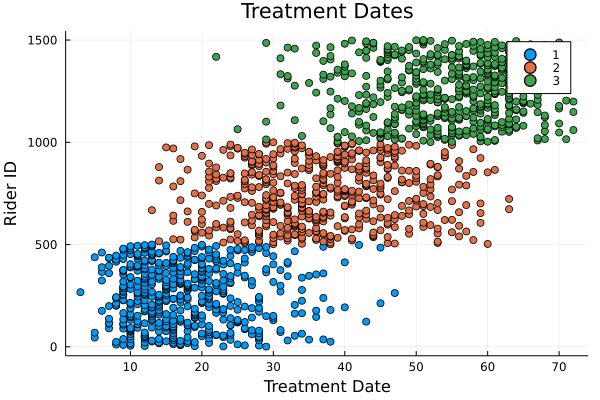

In [14]:
## Plot recruitment patterns ##
recruitment_df = DataFrame(rider_id = 1:Quota, 
    cohort = [panel_array[i].cohort_id for i=1:Quota ],
    treatment_date = [panel_array[i].treatment_date for i=1:Quota ])
@df recruitment_df scatter(
    :treatment_date,
    :rider_id,
    group = :cohort,
    title = "Treatment Dates",
    xlabel = "Treatment Date",
    ylabel = "Rider ID",
    color = :cohort
)

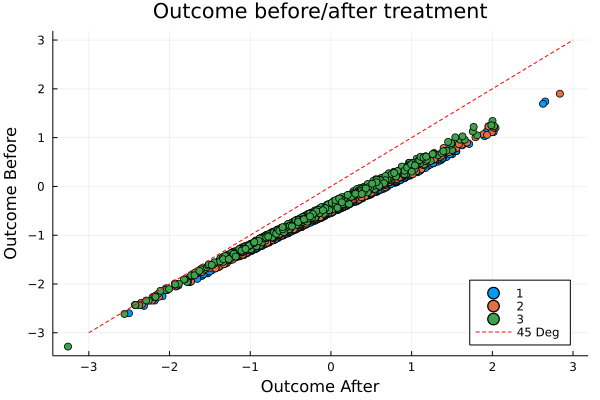

In [64]:
avg_outcome_df = DataFrame(
    rider_id = 1:Quota, 
    cohort = [panel_array[i].cohort_id for i=1:Quota ],
    min_date = [panel_array[i].min_date for i=1:Quota ],
    treatment_date = [panel_array[i].treatment_date for i=1:Quota ],
    max_date = [panel_array[i].max_date for i=1:Quota ],
    avg_outcome_before = [mean([panel_array[i].outcomes[t].y for t=1:(panel_array[i].treatment_date-panel_array[i].min_date)]) for i=1:Quota],
    avg_outcome_after = [mean([panel_array[i].outcomes[t].y for t=(panel_array[i].treatment_date-panel_array[i].min_date + 1):(panel_array[i].max_date-panel_array[i].min_date + 1)]) for i=1:Quota]
)

@df avg_outcome_df scatter(
    :avg_outcome_before,
    :avg_outcome_after,
    group = :cohort,
    title = "Outcome before/after treatment",
    xlabel = "Outcome After",
    ylabel = "Outcome Before",
    color = :cohort
)

plot!(-3:3, -3:3, line=:dash, color=:red, label = "45 Deg", legend=:bottomright)